In [2]:
import plotly.graph_objects as go
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import os
import pandas as pd
import time

from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from plotly.subplots import make_subplots


class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)


class SolarOrbit(object):
    # initiate a class
    def __init__(self, centre_name, object_name, frame):
        self.centre_name = centre_name
        self.object_name = object_name
        self.frame = frame


    def get_position_vector(self, df):
        self.jdtt = df['rcv_time'].compute().to_numpy()
        self.xpos = df['xpos_e2s'].compute().to_numpy()
        self.ypos = df['ypos_e2s'].compute().to_numpy()
        self.zpos = df['zpos_e2s'].compute().to_numpy()


    def make_sun_centre(self):
        if self.object_name == 'sun':
            self.xpos = self.xpos * (-1.0)
            self.ypos = self.ypos * (-1.0)
            self.zpos = self.zpos * (-1.0)
            self.object_name = self.centre_name
            self.centre_name = 'sun'


    def get_satellite_trajectory(self, df):
        self.utc_time = df['rcv_time'].compute().to_numpy()
        self.tra_x_i = df['xpos_i'].compute().to_numpy()
        self.tra_y_i = df['ypos_i'].compute().to_numpy()
        self.tra_z_i = df['zpos_i'].compute().to_numpy()
        if self.tra_x_i.__len__() != self.xpos.__len__():
            raise ValueError('The lengths of the trajectory data and the \
                             vector date do not conform')


    def normalise_tractory(self):
        length_vector = np.linalg.norm(np.c_[self.tra_x_i, self.tra_y_i, self.tra_z_i], axis=1)
        self.tra_x_i = self.tra_x_i / length_vector
        self.tra_y_i = self.tra_y_i / length_vector
        self.tra_z_i = self.tra_z_i / length_vector


class InputFile(object):
    # define a class named InputFile
    def __init__(self, flag, year, month, dir_path):
        self.flag = flag
        self.month = month
        self.dir_path = dir_path
        self.year = year

    # return all the attitude file paths
    def io_file_paths(self):
        """ This is a function to return the file paths for the flag data.

        Args:
            flag (str): the flag indicating file type

        Return:
            path_list (string array):
        """
        if self.month < 10:
            month_str = '0' + str(self.month)
        else:
            month_str = str(self.month)

        rootdir = self.dir_path + month_str

        self.path_list = []
        list_file = os.listdir(rootdir)
        for i in range(0, len(list_file)):
            com_path = os.path.join(rootdir, list_file[i])
            if os.path.isfile(com_path):
                if (self.flag in com_path):
                    if 'swp' not in com_path:  # prevent vim openness intercepting
                        self.path_list.append(com_path)

        self.days = self.path_list.__len__()

        try:
            if self.flag in ['0333', '0866']:
                # extract the year of this directory to check it's leap year or not
                year_this_month = int(self.path_list[0][-11: -7])
                # extract the month to obtain the date in this month to check whether the input files are complete
                month_this_month = int(self.path_list[0][-6: -4])

            # output file name
            self.output_filename = '..//output//' + month_str + '//taiji-01-0811-attitude-' + \
                str(year_this_month) + '-' + month_str + '.txt'
        except:
            raise ValueError('The format of the input file(s) is not correct')

        return self.path_list, self.output_filename, self.days

    # read attitude data from files

    def read_data(self, flag):
        """ This is a function to read attitude data from the files. Due to the vast differences for
            different file types, the read_file_type_data function is varied from type to type

        Args:
            filepaths (string array): the string array containing the attitude file paths
        """

        # hedaer dictionary for different files
        header_dict = {'0811': ['卫星时间', '无拖曳与姿态控制工作模式', '姿态确定模式', '角速度确定模式',
                                '轨道有效标志', '保留1', '陀螺已连续积分时间(s)', '保留2', '冷推控制模式', '量轮控制模式',
                                '磁力矩器控制模式', '自主转入对地定向使能状态', '冷气微推力器速率阻尼允许/禁止状态',
                                '星敏仲裁屏蔽状态', 'Wbi 磁控速率阻尼允许/禁止状态', '双星敏定姿允许/禁止状态',
                                '保留3', '保留4', '星敏感器角速度工作状态字', '进安全模式原因标识',
                                '用于控制的本体系太阳矢量状态', '用于控制的本体系地磁矢量状态', '星敏感器四元数工作状态字',
                                '光纤陀螺工作状态字', '太敏工作状态字', '磁强计工作状态字', '保留5', '保留6', '保留7', '保留8',
                                '磁力矩器输出屏蔽状态', '磁力矩器 X 轴极性', '磁力矩器 Y 轴极性', '磁力矩器 Z 轴极性',
                                '磁力矩器发出指令电压 X大小', '磁力矩器发出指令电压 Y大小', '磁力矩器发出指令电压 Z大小',
                                '磁力矩器发出指令电压 X方向', '磁力矩器发出指令电压 Y方向', '磁力矩器发出指令电压 Z方向',
                                '动量轮工作状态', '动量轮转速有效标志', '动量轮通讯状态标志', '星敏 A 接口状态字',
                                '星敏 A 单机状态字', '星敏 B 接口状态字', '星敏 B 单机状态字', '陀螺 A 接口状态字',
                                '陀螺 A 单机状态字', '陀螺 B 接口状态字', '陀螺 B 单机状态字', '冷气微推力器 1 工作状态',
                                '冷气微推力器 2 工作状态', '冷气微推力器 3 工作状态', '冷气微推力器 4 工作状态',
                                '冷气微推力器 5 工作状态', '冷气微推力器 6 工作状态', '冷气微推力器 7 工作状态',
                                '冷气微推力器 8 工作状态', '冷气微推力器输出屏蔽状态', '冷气微推力器 1 指令喷气时长(ms)',
                                '冷气微推力器 2 指令喷气时长(ms)', '冷气微推力器 3 指令喷气时长(ms)',
                                '冷气微推力器 4 指令喷气时长(ms)', '冷气微推力器 5 指令喷气时长(ms)',
                                '冷气微推力器 6 指令喷气时长(ms)', '冷气微推力器 7 指令喷气时长(ms)',
                                '冷气微推力器 8 指令喷气时长(ms)', '太阳矢量与-Yb 轴的夹角', '轨道系姿态角 X',
                                '轨道系姿态角 Y', '轨道系姿态角 Z', '惯性系姿态角速度 X', '惯性系姿态角速度 Y',
                                '惯性系姿态角速度 Z', '轨道系角速度 Wbox', '轨道系角速度 Wboy', '轨道系角速度 Wboz',
                                '导引律控制坐标系欧拉角X', '导引律控制坐标系欧拉角Y', '导引律控制坐标系欧拉角Z',
                                '惯性系姿态角 X', '惯性系姿态角 Y', '惯性系姿态角 Z', '本体系磁矢量 X', '本体系磁矢量 Y',
                                '本体系磁矢量 Z', '本体系太阳矢量 X', '本体系太阳矢量 Y', '本体系太阳矢量 Z', 'WTF',
                                'WTF1', 'WTF2'],
                       '0111': ['rcv_time', 'eps_time'],
                       '0333': ['rcv_time', 'xpos_e2s', 'ypos_e2s', 'zpos_e2s'],
                       '0866': ['rcv_time', 'xpos_i', 'ypos_i', 'zpos_i', 'rxvel_i', 'ryvel_i', 'rzvel_i']}

        # the dtype for different columns
        dtype_dict = {'0811': {'卫星时间': str, '惯性系姿态角 X': np.float64,
                               '惯性系姿态角 Y': np.float64, '惯性系姿态角 Z': np.float64,
                               '轨道系姿态角 X': np.float64, '轨道系姿态角 Y': np.float64,
                               '轨道系姿态角 Z': np.float64},
                      '0111': {'rcv_time': np.float64, 'eps_time': np.float64},
                      '0333': np.float64,
                      '0866': np.float64}

        # the new column
        new_header_dict = {'0811': ['rcv_time', 'igrf_eul_x', 'igrf_eul_y', 'igrf_eul_z',
                                    'tf_eul_x', 'tf_eul_y', 'tf_eul_z'],
                           '0111': ['rcv_time', 'eps_time'],
                           '0333': ['rcv_time', 'xpos_e2s', 'ypos_e2s', 'zpos_e2s'],
                           '0866': ['rcv_time', 'xpos_i', 'ypos_i', 'zpos_i', 'rxvel_i', 'ryvel_i', 'rzvel_i']}

        # used columns
        used_column_dict = {'0811': ['卫星时间', '惯性系姿态角 X', '惯性系姿态角 Y', '惯性系姿态角 Z',
                                     '轨道系姿态角 X', '轨道系姿态角 Y', '轨道系姿态角 Z'],
                            '0111': ['rcv_time', 'eps_time'],
                            '0333': ['rcv_time', 'xpos_e2s', 'ypos_e2s', 'zpos_e2s'],
                            '0866': ['rcv_time', 'xpos_i', 'ypos_i', 'zpos_i', 'rxvel_i', 'ryvel_i', 'rzvel_i']}

        # sep dictionary
        sep_dict = {'0811': ',', '0111': '\s+', '0333': '\s+', '0866': '\s+'}

        # skiprow
        skiprows_dict = {'0811': 2, '0111': 31, '0333': 0, '0866': 50}
        self.df = dd.read_csv(urlpath=self.path_list, sep=sep_dict[flag], header=None,
                              engine='c', skiprows=skiprows_dict[flag],
                              storage_options=dict(auto_mkdir=False), names=header_dict[flag],
                              dtype=dtype_dict[flag], encoding='gb2312')
        self.df = self.df[used_column_dict[flag]]
        self.df = self.df.rename(columns=dict(
            zip(self.df.columns, new_header_dict[flag])))
        self.df = self.df.drop_duplicates(subset=['rcv_time'])

        return self.df


def get_run_time(func):
    def call_func(*args, **kwargs):
        begin_time = time.time()
        ret = func(*args, **kwargs)
        end_time = time.time()
        run_time = end_time - begin_time
        print(str(func.__name__) + "函数运行时间为" + str(run_time))
        return ret
    return call_func


def axisEqual3D(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))()
                        for dim in 'xyz'])
    sz = extents[:, 1] - extents[:, 0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize / 2
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - 3 * r, ctr + 3 * r)

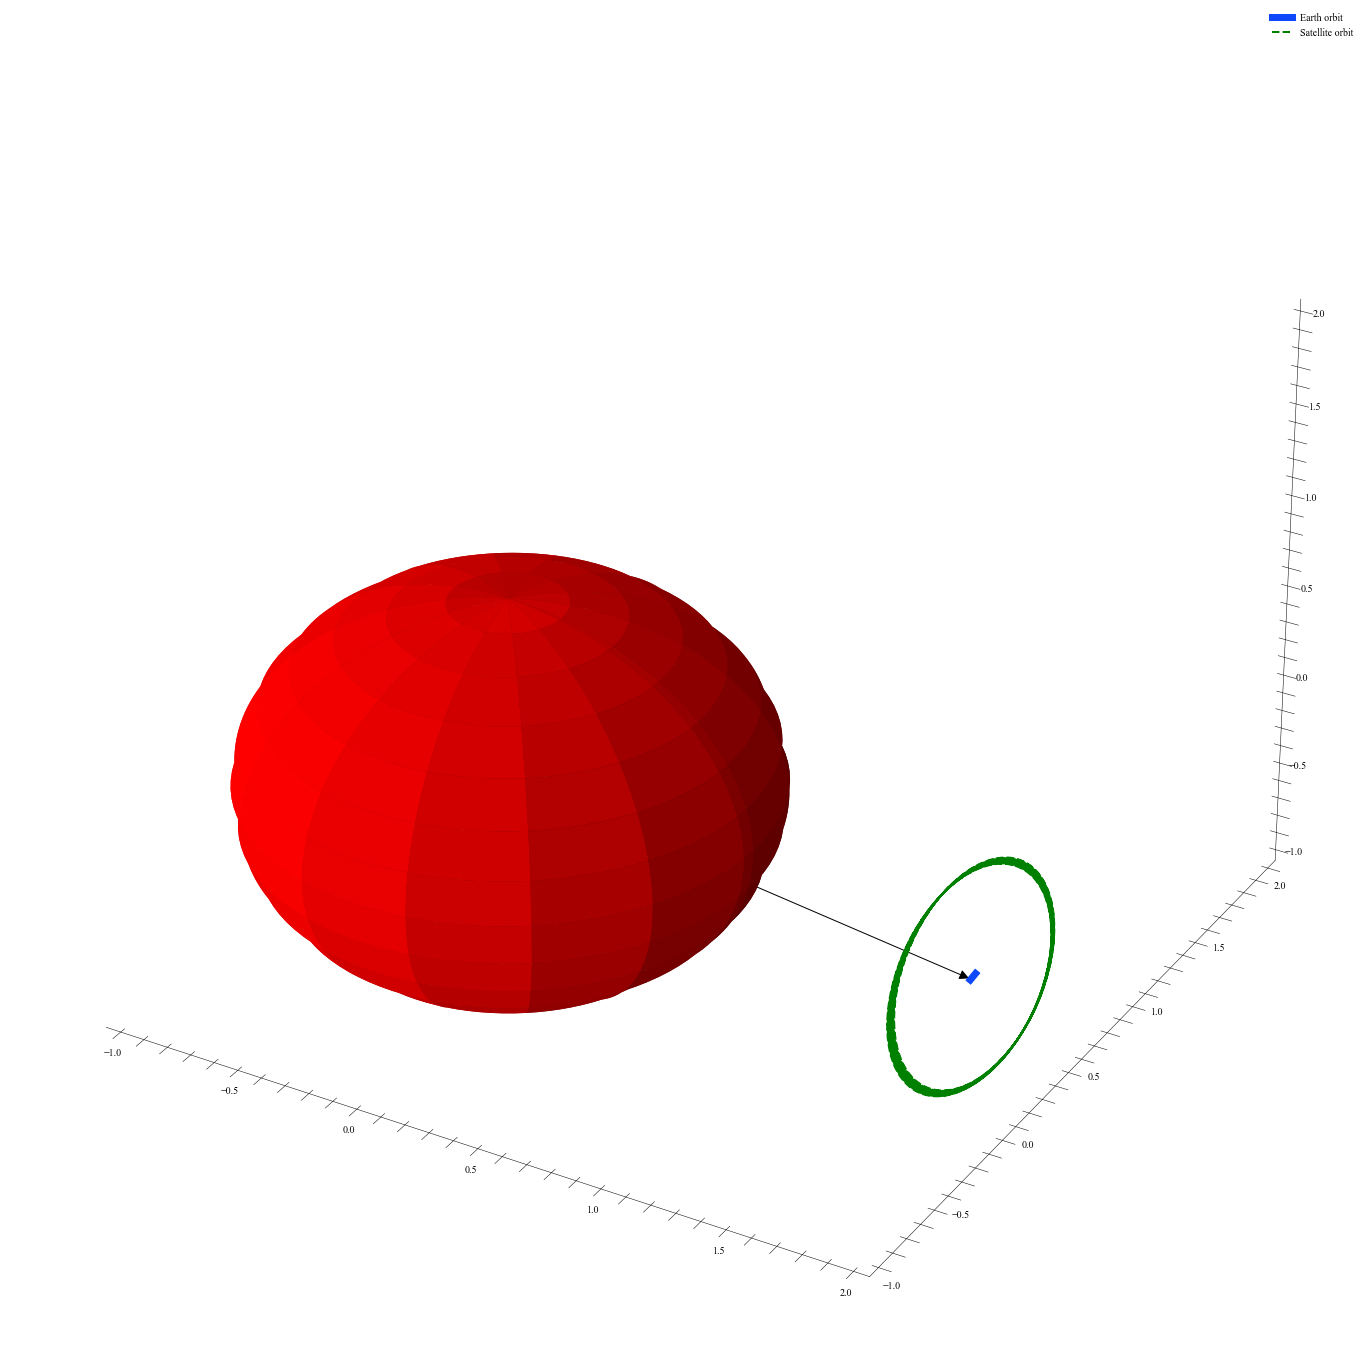

In [22]:
def main(year, month):
    # read Earth to Sun files
    e2s_file = InputFile(flag='0333', year=year, month=month, dir_path='..//output//')
    e2s_file.path_list, e2s_file.output_filename, e2s_file.days = e2s_file.io_file_paths()
    e2s_file.df = e2s_file.read_data('0333')

    # read the gcrs satellite positions file
    posi_file = InputFile(flag='0866', year=year,
                         month=month, dir_path='..//output//')
    posi_file.path_list, posi_file.output_filename, posi_file.days = posi_file.io_file_paths()
    posi_file.df = posi_file.read_data('0866')

    e2s20190916 = SolarOrbit('earth', 'sun', 'gcrs')
    e2s20190916.get_position_vector(e2s_file.df)
    e2s20190916.make_sun_centre()
    e2s20190916.get_satellite_trajectory(posi_file.df)
    e2s20190916.normalise_tractory()
    
    u, v = np.mgrid[0: 2 * np.pi: 100j, 0: np.pi: 100j]
    x = np.cos(u) * np.sin(v)
    y = np.sin(u) * np.sin(v)
    z = np.cos(v)
    

    plt.style.use(['science', 'no-latex', 'high-vis'])
    fig = plt.figure(figsize=[50, 25])
    ax = fig.gca(projection='3d')
    # ax.set_aspect('auto')
    axisEqual3D(ax)
    ax.plot_surface(x, y, z, color='red', rstride=7, cstride=7)
    # make the panes transparent
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] = (1, 1, 1, 0)
    ax.yaxis._axinfo["grid"]['color'] = (1, 1, 1, 0)
    ax.zaxis._axinfo["grid"]['color'] = (1, 1, 1, 0)
    # plt.axis('off')
    plt.grid(b=None)

    # plot the earth trajectory
    ax.plot(e2s20190916.xpos * 2, e2s20190916.ypos * 2, e2s20190916.zpos * 2, linewidth=7, label='Earth orbit')
    ax.plot(e2s20190916.xpos * 2 + e2s20190916.tra_x_i * 0.5,
            e2s20190916.ypos * 2 + e2s20190916.tra_y_i * 0.5,
            e2s20190916.zpos * 2 + e2s20190916.tra_z_i * 0.5, linewidth=2, label='Satellite orbit', color='green')
    a = Arrow3D([0, e2s20190916.xpos[10000] * 2], [0, e2s20190916.ypos[10000] * 2],
                [0, e2s20190916.zpos[10000] * 2], mutation_scale = 20,
                lw=1, arrowstyle="-|>", color="k")
    ax.add_artist(a)
    plt.legend()
    # plt.show()
    
    fig = go.Figure(data=[go.Surface(x=[1], y=[1], z=[1])])
    fig.update_layout()
    fig.show()

if __name__ == '__main__':
    main(2019, 9)

In [5]:
def main(year, month):
    # read Earth to Sun files
    e2s_file = InputFile(flag='0333', year=year, month=month, dir_path='..//output//')
    e2s_file.path_list, e2s_file.output_filename, e2s_file.days = e2s_file.io_file_paths()
    e2s_file.df = e2s_file.read_data('0333')

    # read the gcrs satellite positions file
    posi_file = InputFile(flag='0866', year=year,
                         month=month, dir_path='..//output//')
    posi_file.path_list, posi_file.output_filename, posi_file.days = posi_file.io_file_paths()
    posi_file.df = posi_file.read_data('0866')

    e2s20190916 = SolarOrbit('earth', 'sun', 'gcrs')
    e2s20190916.get_position_vector(e2s_file.df)
    e2s20190916.make_sun_centre()
    e2s20190916.get_satellite_trajectory(posi_file.df)
    e2s20190916.normalise_tractory()
    
    u, v = np.mgrid[0: 2 * np.pi: 100j, 0: np.pi: 100j]
    x = np.cos(u) * np.sin(v)
    y = np.sin(u) * np.sin(v)
    z = np.cos(v)
    
    fig = go.Figure(data=[go.Surface(x=x, y=y, z=z, showscale=False)])
    fig.update_layout()
    fig.show()

if __name__ == '__main__':
    main(2019, 9)

TypeError: invalid Figure property: size